## Data Labs 2025 - Primary Production 2025

This notebook demonstrates how to access and process the dataset used in updated Lab 7 Primary Production of the revised 2025 OOI Lab Manual.

By Sage Lichtenwalner, December 2, 2024

First, let's create plots of Chlorophyll and Nitrate for each of three surface moorings in the OOI Pioneer NES Array.

Nitrate (Suna) Sensors
* ooi-cp03issm-rid26-07-nutnrb000
* ooi-cp01cnsm-rid26-07-nutnrb000
* ooi-cp04ossm-rid26-07-nutnrb000

Fluorometers
* ooi-cp03issm-rid27-02-flortd000
* ooi-cp01cnsm-rid27-02-flortd000
* ooi-cp04ossm-rid27-02-flortd000


In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

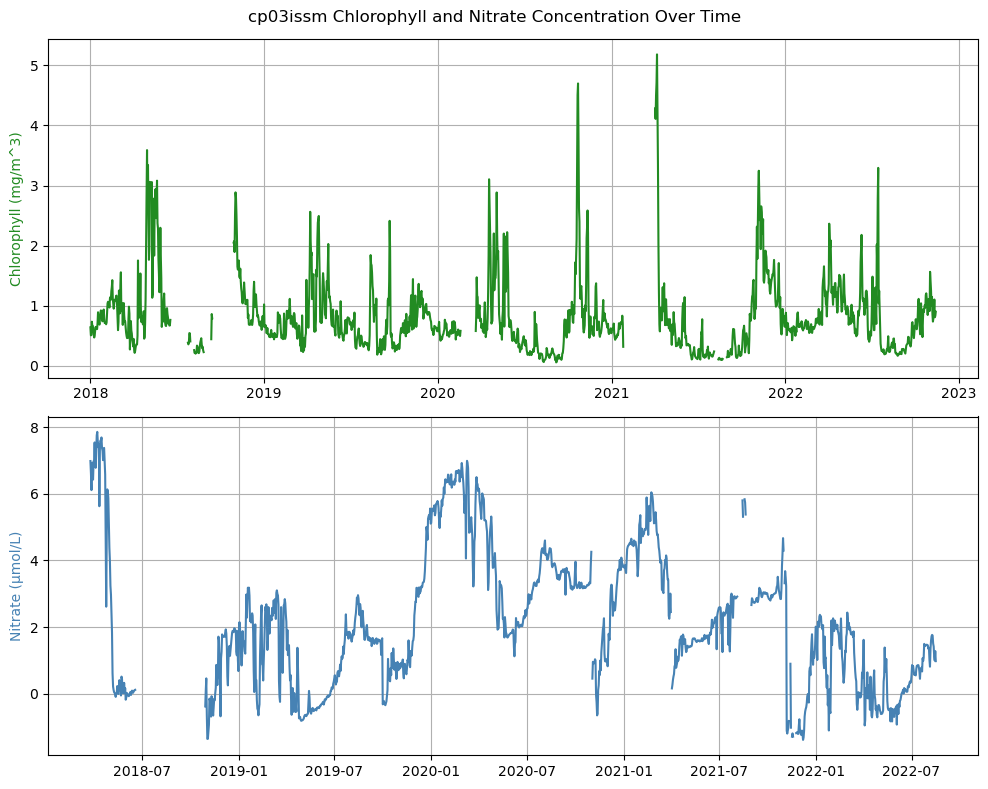

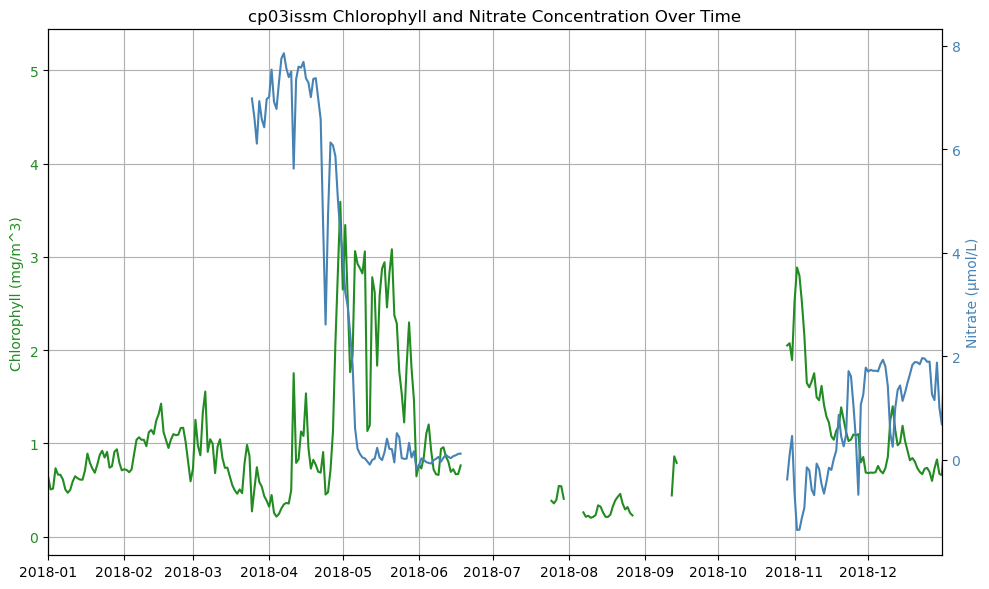

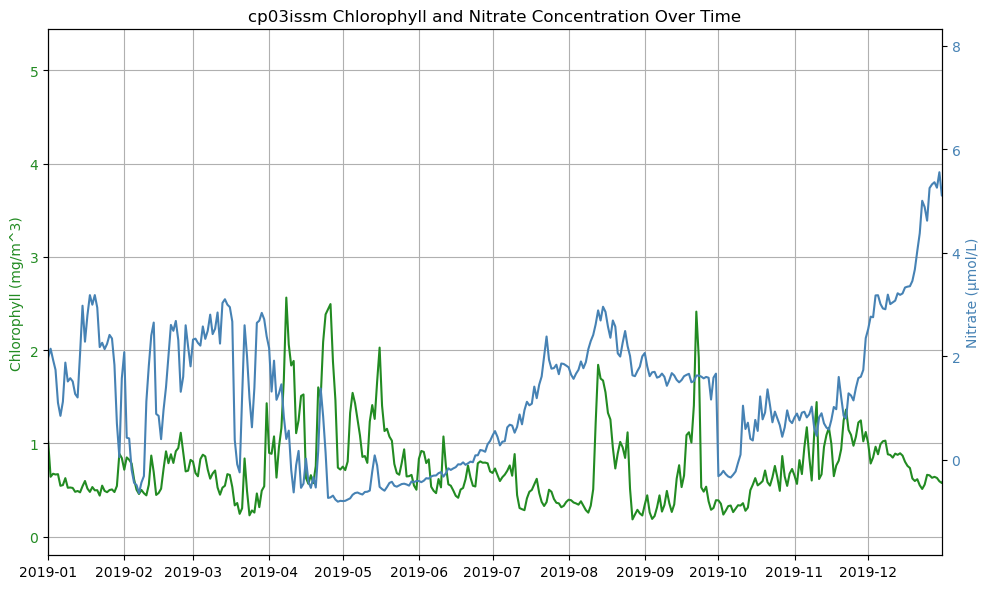

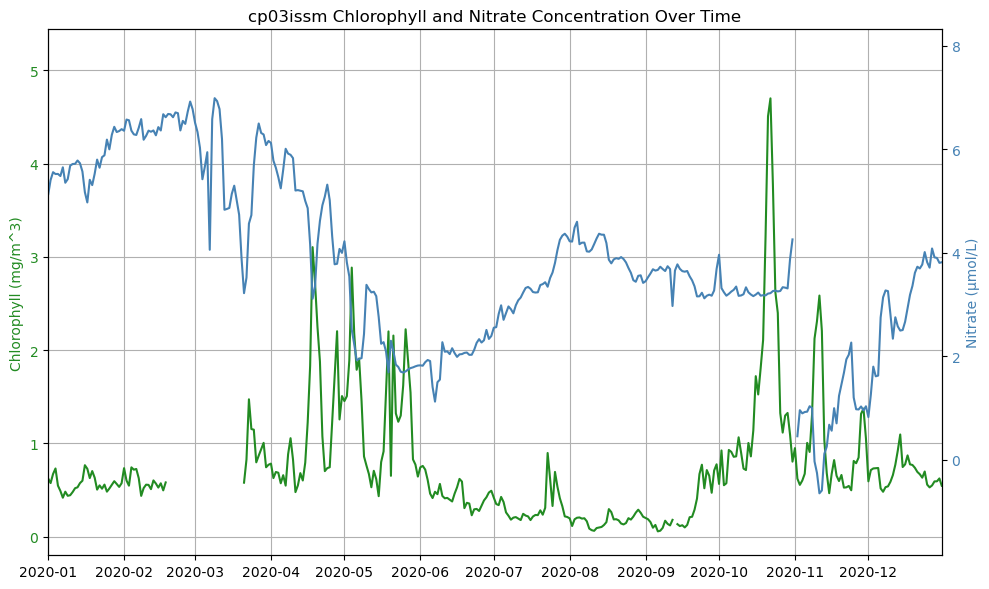

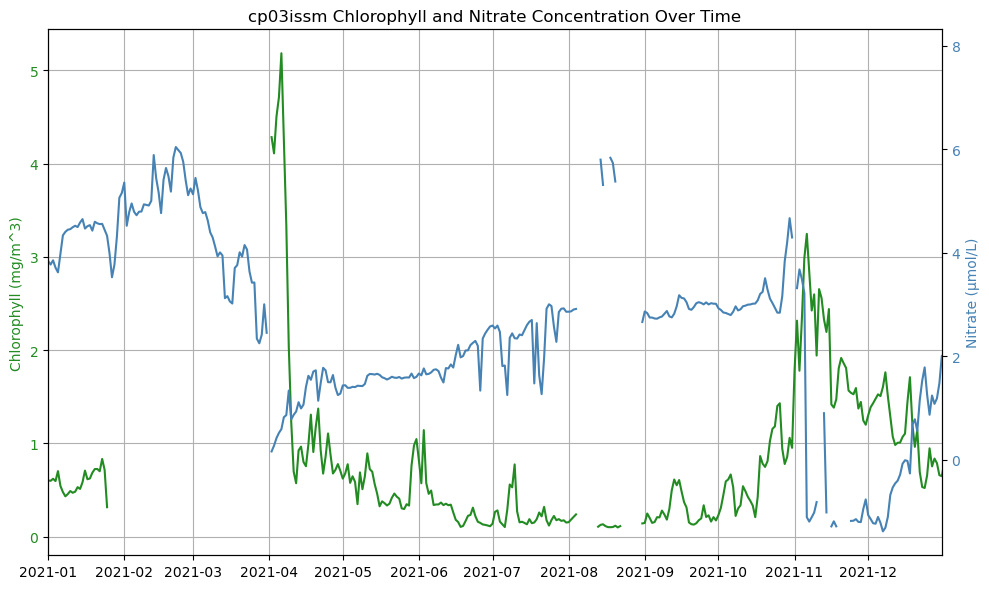

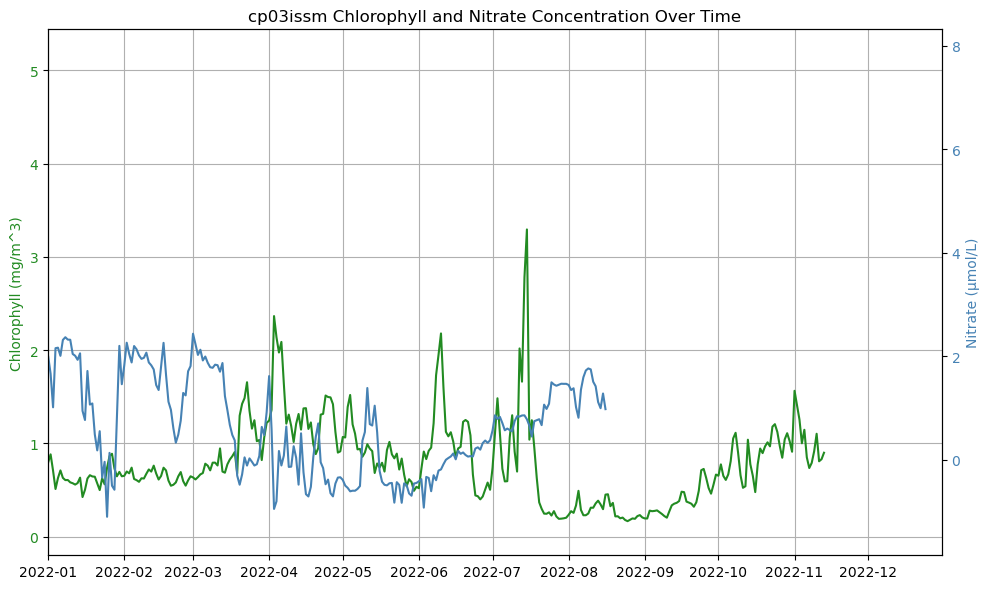

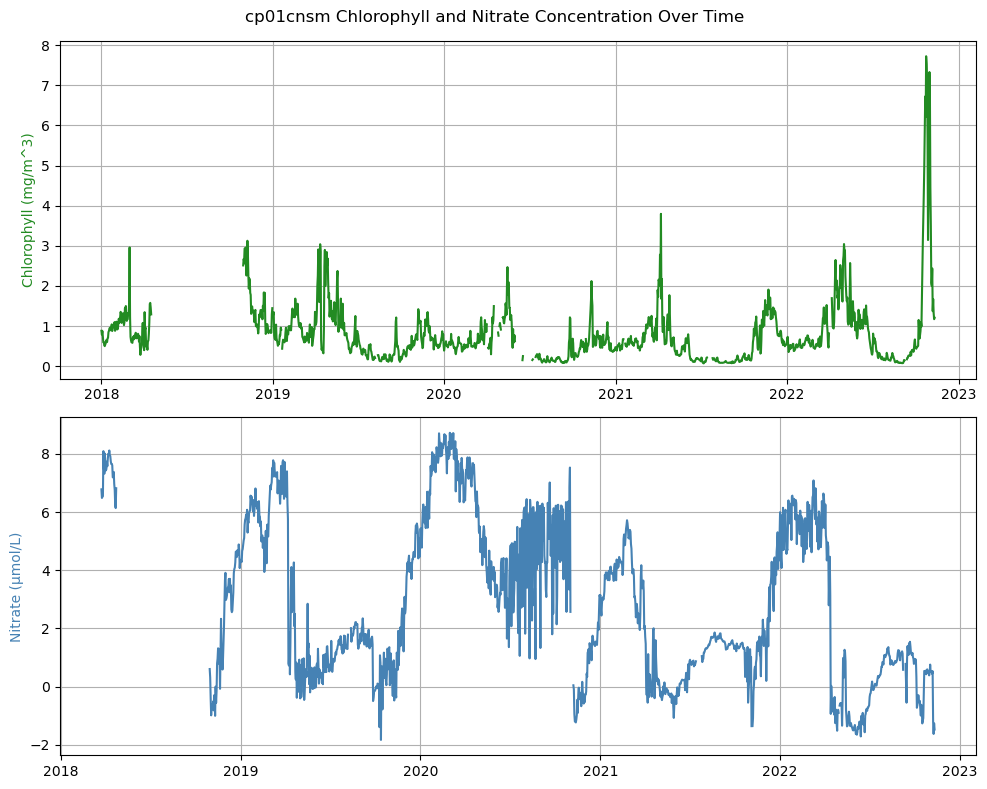

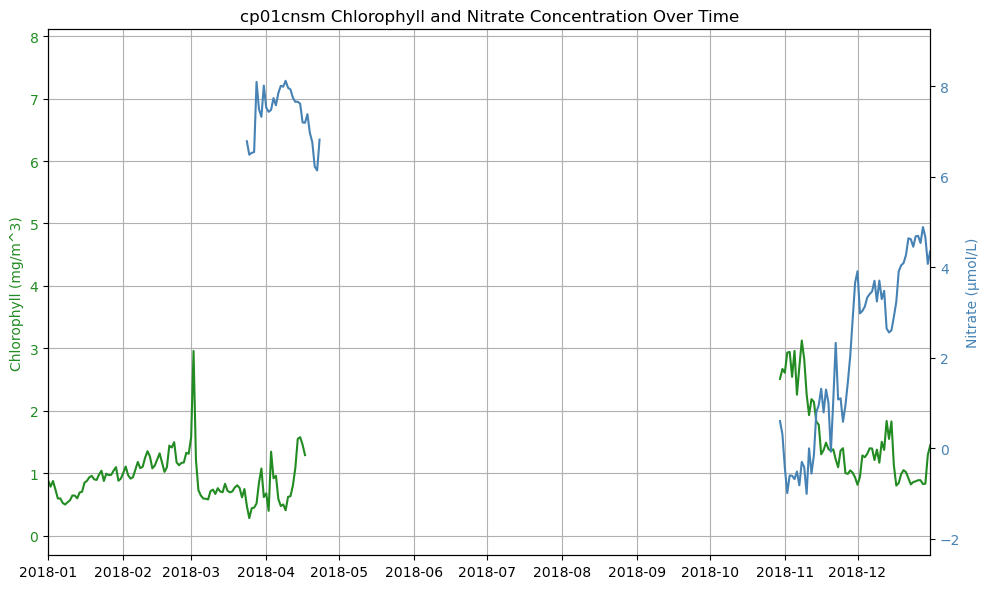

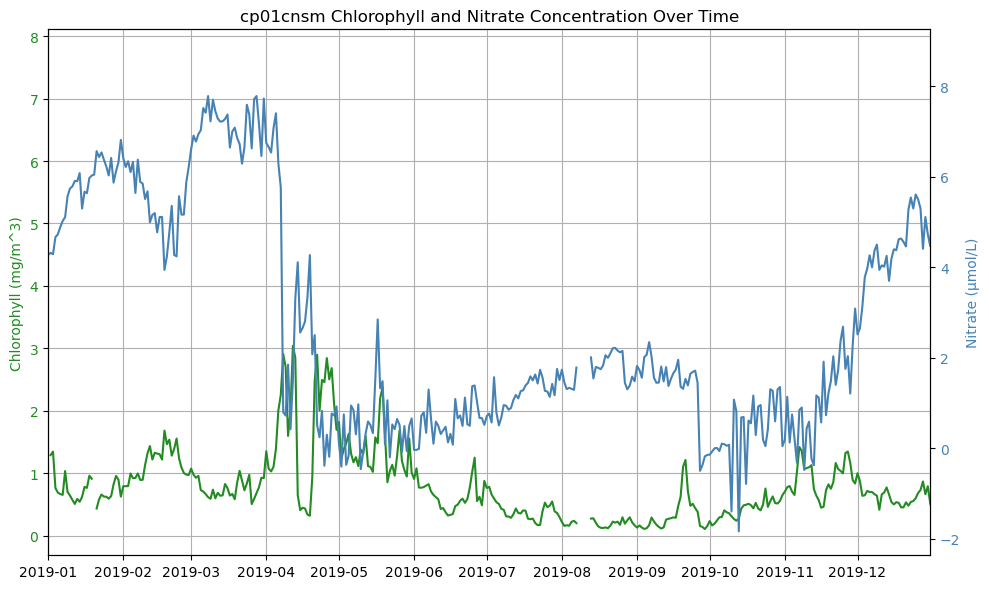

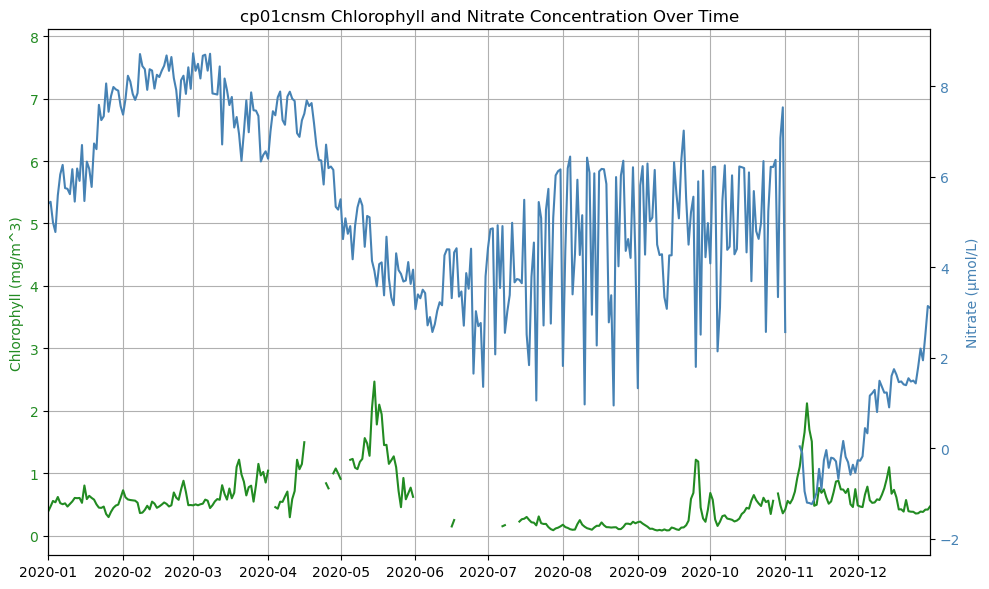

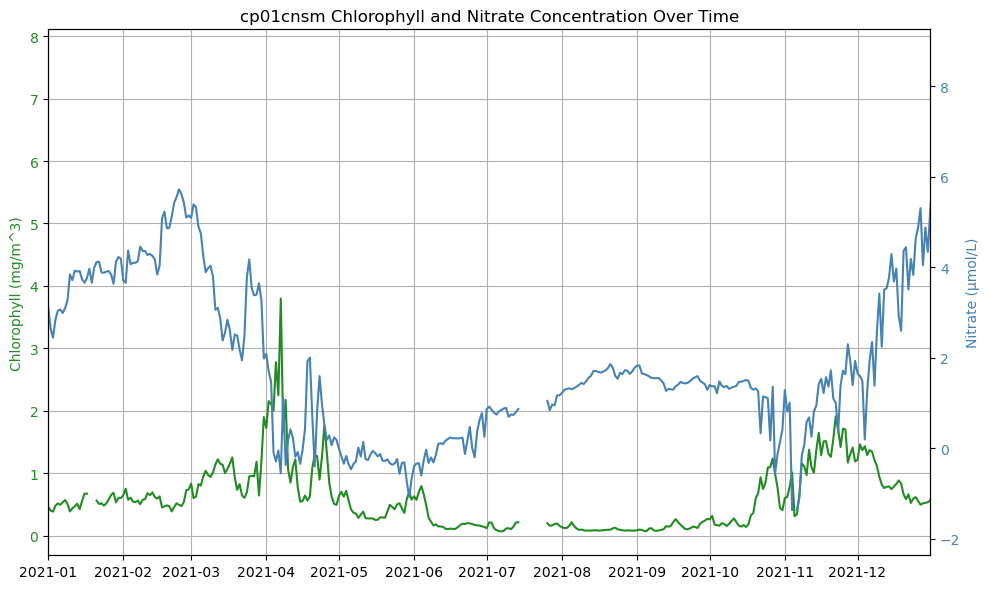

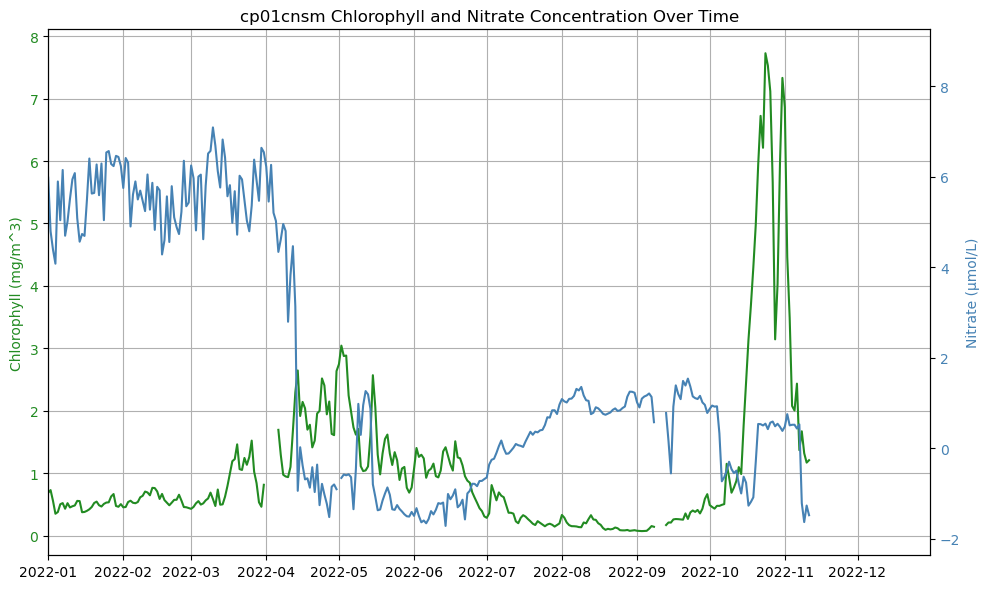

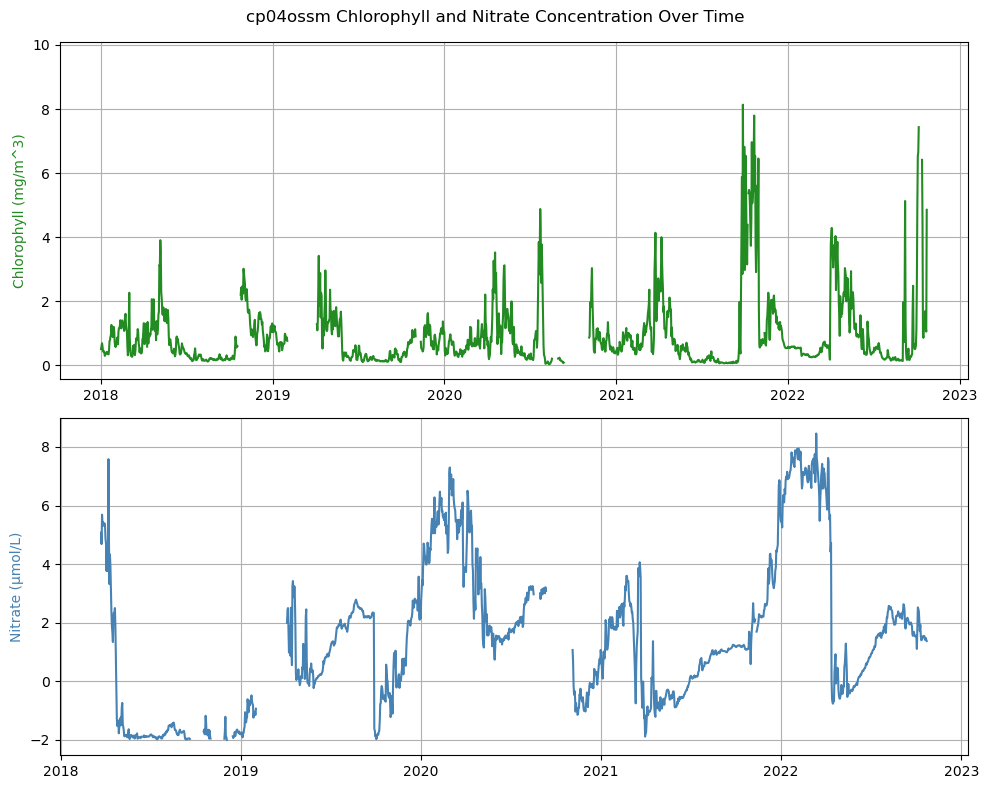

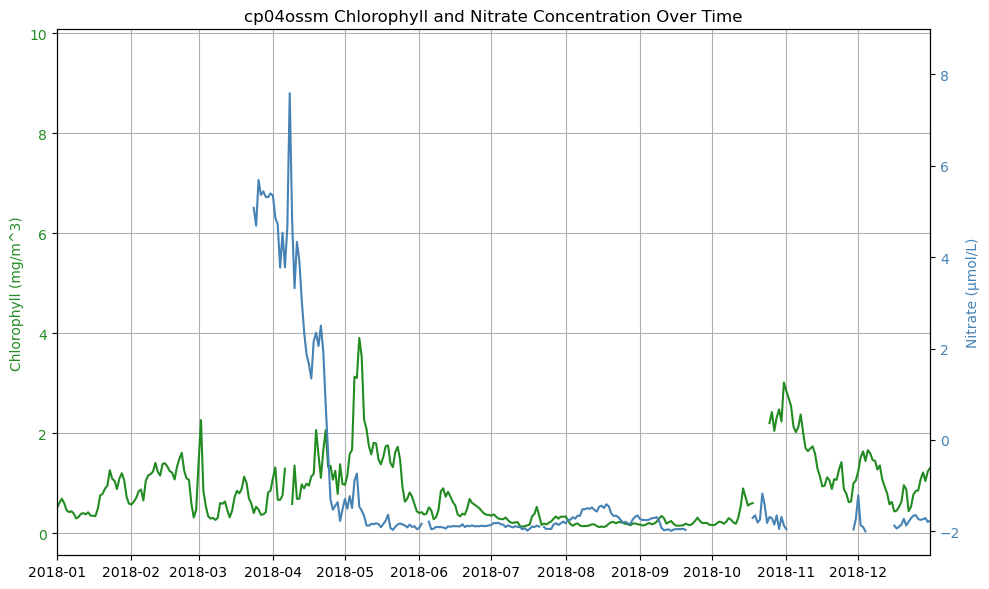

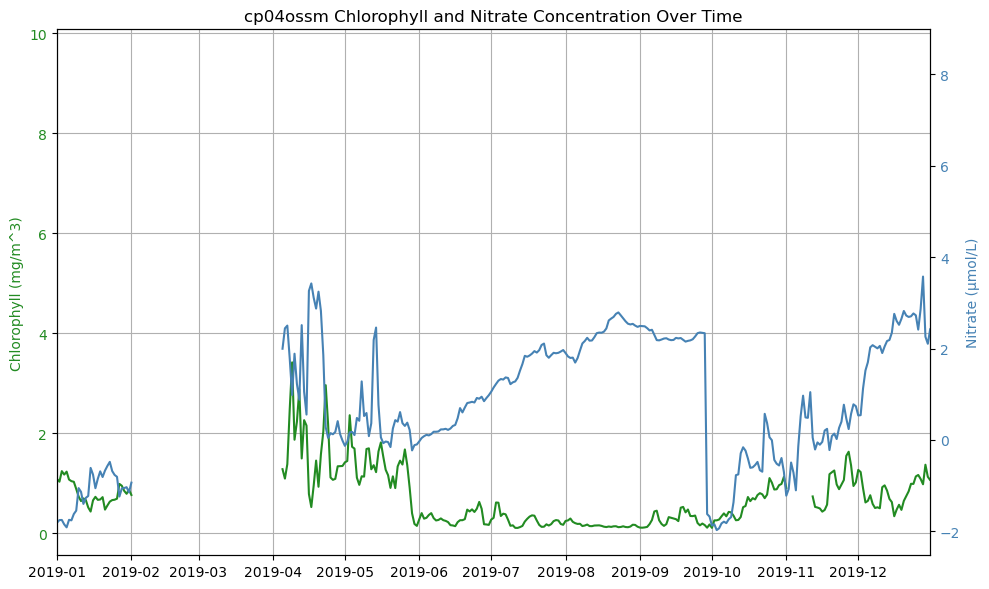

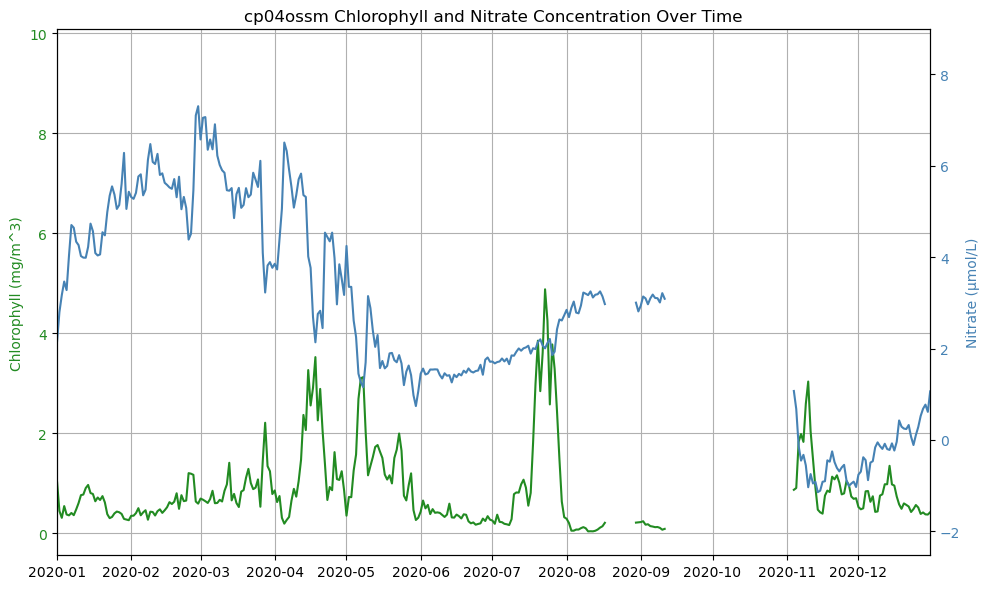

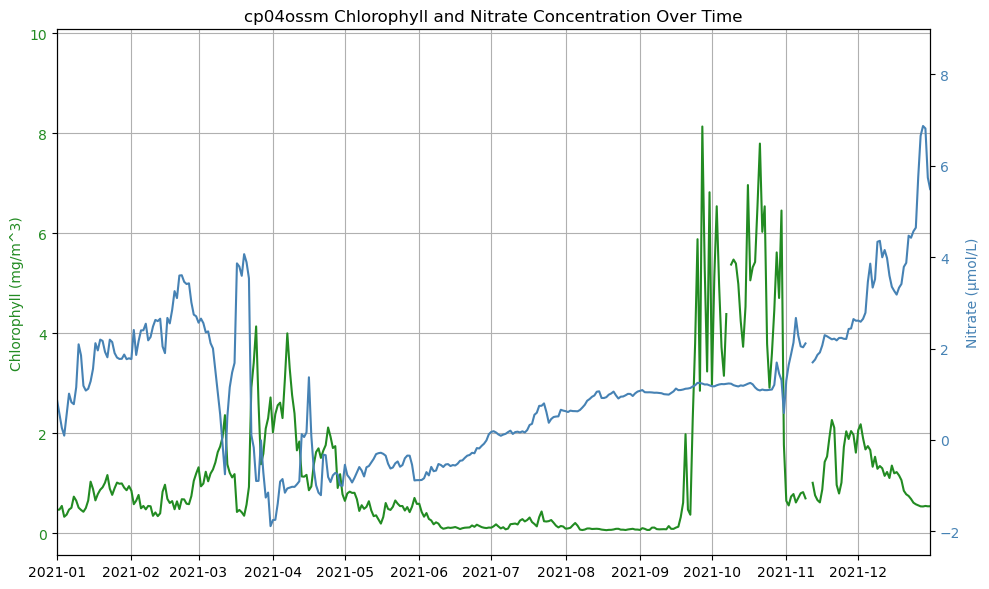

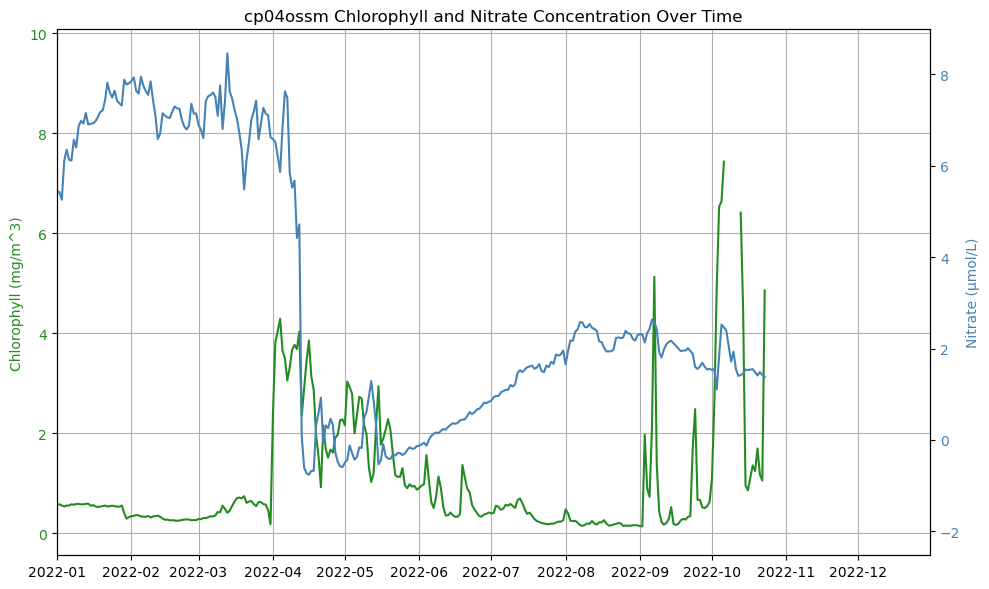

In [34]:
def clean_data(data,min=0,max=100):
  data = data.where((data>min) & (data<max))
  return data

for mooring in ['cp03issm','cp01cnsm','cp04ossm']:
    # Load the Chlorophyll data
    url_flort = e.get_download_url(
      dataset_id = 'ooi-%s-rid27-02-flortd000' % mooring,
      variables = ['time','mass_concentration_of_chlorophyll_a_in_sea_water','sea_water_practical_salinity','sea_water_temperature'],
      constraints = { "time>=": "2018-01-01", "time<=": "2024-01-01",}
    )
    df_flort = pd.read_csv(url_flort, index_col='time', parse_dates=True, skiprows=[1])

    # Offshore has high values in 2022, let's trim them
    df_flort['mass_concentration_of_chlorophyll_a_in_sea_water'] = clean_data(df_flort['mass_concentration_of_chlorophyll_a_in_sea_water'],0,10)
    
    # Resample the data to daily averages
    df_flort_avg = df_flort.resample('D').mean()

    # Load the Nitrate data
    url_nutnr = e.get_download_url(
      dataset_id = 'ooi-%s-rid26-07-nutnrb000' % mooring,
      variables = ['time','mole_concentration_of_nitrate_in_sea_water_suna','mole_concentration_of_nitrate_in_sea_water_suna_qc_agg'],
      constraints = { "time>=": "2018-01-01", "time<=": "2024-01-01",}
    )    
    df_nutnr = pd.read_csv(url_nutnr, index_col='time', parse_dates=True, skiprows=[1])

    # Only include data that has passed the QC test, excpt for the offshore mooring which has no QC test
    if (mooring in ['cp03issm','cp01cnsm']):
      df_nutnr['good_nitrate'] = df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna'].where(df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna_qc_agg'] == 1)
    else:
       df_nutnr['good_nitrate'] = clean_data(df_nutnr['mole_concentration_of_nitrate_in_sea_water_suna'], -2, 10)
    
    # Resample the data to daily averages
    df_nutnr_avg = df_nutnr.resample('D').mean()

    # Plot Chlorophyll and Nitrate Concentration Over Time
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(df_flort_avg.index, df_flort_avg['mass_concentration_of_chlorophyll_a_in_sea_water'], color='forestgreen')
    ax1.set_ylabel('Chlorophyll (mg/m^3)', color='forestgreen')
    ax1.grid(True)
    ax2.plot(df_nutnr_avg.index, df_nutnr_avg['good_nitrate'], color='steelblue')
    ax2.set_ylabel('Nitrate (µmol/L)', color='steelblue')
    ax2.grid(True)

    plt.suptitle('%s Chlorophyll and Nitrate Concentration Over Time' % mooring)
    plt.tight_layout()
    plt.savefig('%s_chlorophyll_nitrate.png' % (mooring))
    
    for year in np.arange(2018,2023):
      fig, ax1 = plt.subplots(figsize=(10, 6))
    
      # Plot Chlorophyll on the left y-axis
      ax1.plot(df_flort_avg.index, df_flort_avg['mass_concentration_of_chlorophyll_a_in_sea_water'], color='forestgreen')
      ax1.set_ylabel('Chlorophyll (mg/m^3)', color='forestgreen')
      ax1.tick_params(axis='y', labelcolor='forestgreen')
      plt.grid(True)

      # Create a second y-axis for Nitrate
      ax2 = ax1.twinx()
      ax2.plot(df_nutnr_avg.index, df_nutnr_avg['good_nitrate'], color='steelblue')
      ax2.set_ylabel('Nitrate (µmol/L)', color='steelblue')
      ax2.tick_params(axis='y', labelcolor='steelblue')

      plt.title('%s Chlorophyll and Nitrate Concentration Over Time' % mooring)
      plt.xlim(pd.to_datetime(('%s-01-01') % year), pd.to_datetime(('%s-12-31' % year)))
      plt.tight_layout()
      plt.savefig('%s_chlorophyll_nitrate_%s.png' % (mooring, year))
